In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(42)

# Generate a long time series with seasonality
t_long = np.arange(0, 365*3)  # Three years of data
seasonality_long = 10 + np.sin(2 * np.pi * t_long / 365) * 2 + np.random.normal(0, 0.5, size=t_long.size)

# Generate a short time series with similar seasonality but less data
t_short = np.arange(0, 365)  # One year of data
seasonality_short = 10 + np.sin(2 * np.pi * t_short / 365) * 2 + np.random.normal(0, 0.5, size=t_short.size)

# Plot both time series
plt.figure(figsize=(14, 6))
plt.plot(t_long, seasonality_long, label='Long Time Series')
plt.plot(t_short, seasonality_short, label='Short Time Series', color='orange')
plt.legend()
plt.show()


In [ ]:
import pymc3 as pm

with pm.Model() as model:
    # Priors based on the long time series
    amplitude = pm.Normal('amplitude', mu=2, sd=0.5)
    phase = pm.Normal('phase', mu=0, sd=0.5)
    
    # The observed seasonality in the short time series
    observed_seasonality = pm.Normal('observed_seasonality', mu=10 + amplitude * np.sin(2 * np.pi * t_short / 365 + phase), sd=0.5, observed=seasonality_short)
    
    # Inference
    trace = pm.sample(2000, return_inferencedata=False)


In [ ]:
pm.traceplot(trace)
plt.show()

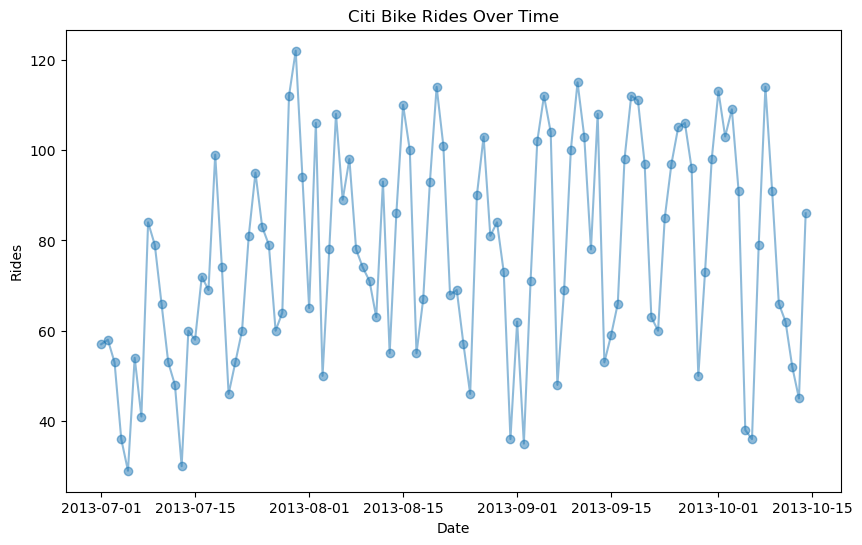

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import pyreadr
result = pyreadr.read_r('citi_bike_360.rds')
citi = result[None]
# First, ensure the 'date' column is converted to datetime objects
citi['date'] = pd.to_datetime(citi['date'])

# Now, when you compare, make sure you compare against a datetime object
citi_train = citi[citi['date'] < datetime.datetime.strptime('2013-10-15', '%Y-%m-%d')]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(citi_train['date'], citi_train['rides'], alpha=0.5)
plt.plot(citi_train['date'], citi_train['rides'], alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Rides')
plt.title('Citi Bike Rides Over Time')
plt.show()


In [2]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast
import statsmodels.api as sm

# Function to create Fourier terms
def fourier_terms(y, K=3):
    t = np.arange(len(y))
    return np.column_stack([np.cos(2 * np.pi * t * k / len(y)) for k in range(1, K + 1)] +
                           [np.sin(2 * np.pi * t * k / len(y)) for k in range(1, K + 1)])

# ARIMA with Fourier terms
rides_ts = citi_train['rides'].values
fourier_terms_for_arima = fourier_terms(rides_ts, K=3)

# Use ARIMA model from statsmodels
arima_model = ARIMA(rides_ts, exog=fourier_terms_for_arima, order=(1,0,1))
arima_result = arima_model.fit()
print(arima_result.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  106
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -463.877
Date:                Sun, 18 Feb 2024   AIC                            947.754
Time:                        23:35:34   BIC                            974.388
Sample:                             0   HQIC                           958.549
                                - 106                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         77.0047      2.819     27.317      0.000      71.480      82.530
x1            -7.4187      4.176     -1.776      0.076     -15.604       0.766
x2            -9.0072      4.097     -2.199      0.0

23:35:35 - cmdstanpy - INFO - Chain [1] start processing
23:35:36 - cmdstanpy - INFO - Chain [1] done processing


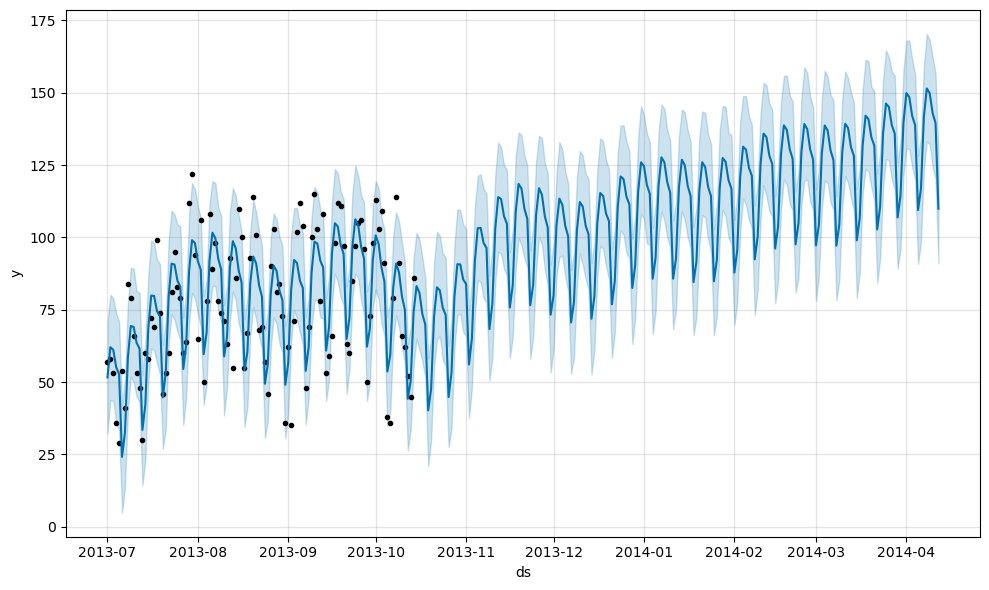

In [3]:
from prophet import Prophet

# Preparing data for Prophet
df_prophet = citi_train[['date', 'rides']].rename(columns={'date': 'ds', 'rides': 'y'})

# Fitting a Prophet model
model_prophet = Prophet(yearly_seasonality=8, weekly_seasonality=3)
model_prophet.fit(df_prophet)

# Make future dataframe and predict
future = model_prophet.make_future_dataframe(periods=180)
forecast = model_prophet.predict(future)

# Plotting the forecast
fig = model_prophet.plot(forecast)


In [4]:
import pymc3 as pm

# Example of translating a simple Stan model to PyMC3
with pm.Model() as model:
    # Priors and model definition similar to the Stan model
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=(12,))
    sigma = pm.HalfNormal('sigma', sd=1)
    
    # Likelihood
    mu = alpha + pm.math.dot(fourier_terms_for_arima, beta)
    y_obs = pm.Normal('y_obs', mu=mu, sd=sigma, observed=rides_ts)
    
    # Sampling
    trace = pm.sample(2000)
    
# Plotting the trace
pm.traceplot(trace)


ValueError: shapes (106,6) and (12,) not aligned: 6 (dim 1) != 12 (dim 0)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=913.607, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=972.763, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=959.777, Time=0.02 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=945.496, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=970.776, Time=0.00 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=929.359, Time=0.10 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=917.049, Time=0.27 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=915.473, Time=0.28 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=930.096, Time=0.05 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=929.312, Time=0.16 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=924.115, Time=0.19 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=913.875, Time=0.13 sec
 ARIMA(2,1,1)(1,0,1)[7] intercept   : AIC=913.103, Time

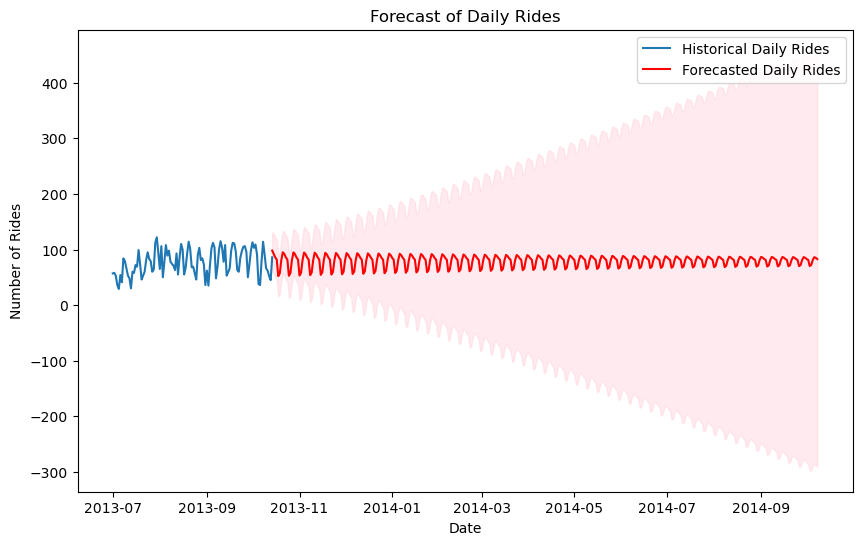

In [7]:
import pandas as pd
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMAResults
import matplotlib.pyplot as plt

# Assuming citi_train is a DataFrame with 'date' and 'rides' columns
# Ensure 'date' is the index
citi_train.index = pd.DatetimeIndex(citi_train['date'])

# Using pmdarima's auto_arima to find the best ARIMA model parameters
auto_arima_model = auto_arima(citi_train['rides'], seasonal=True, m=7, trace=True,
                              error_action='ignore', suppress_warnings=True)

# Summary of the model
print(auto_arima_model.summary())

# Forecasting
n_periods = 360
forecast, conf_int = auto_arima_model.predict(n_periods=n_periods, return_conf_int=True)

# Creating a future dates DataFrame
future_dates = pd.date_range(citi_train['date'].max(), periods=n_periods, freq='D')

# Plotting the forecast along with the confidence interval
plt.figure(figsize=(10, 6))
plt.plot(citi_train['date'], citi_train['rides'], label='Historical Daily Rides')
plt.plot(future_dates, forecast, color='red', label='Forecasted Daily Rides')
plt.fill_between(future_dates, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.title('Forecast of Daily Rides')
plt.xlabel('Date')
plt.ylabel('Number of Rides')
plt.legend()
plt.show()


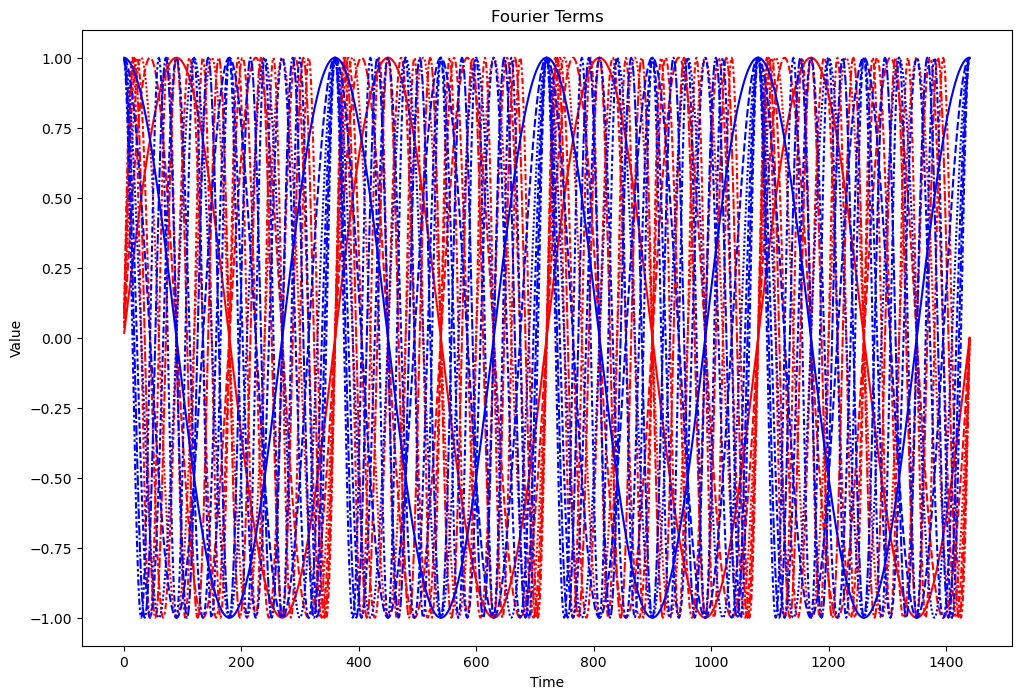

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the period and create a step function
period_length = 360
time = np.arange(1, 4 * period_length + 1)
step_function = np.tile(np.repeat([1, -1], period_length / 2), 4)

# Function to generate Fourier series terms
def fourier_series(time, period, K):
    result = pd.DataFrame(index=time)
    T = period
    for k in range(1, K + 1):
        result[f'sin_{k}'] = np.sin(2 * np.pi * k * time / T)
        result[f'cos_{k}'] = np.cos(2 * np.pi * k * time / T)
    return result

# Generate Fourier terms
K = 6
fouriers = fourier_series(time, period_length, K)

# Reshape for plotting
fouriers_melted = pd.melt(fouriers.reset_index(), id_vars=['index'], var_name='Order', value_name='Value')
fouriers_melted['Order2'] = fouriers_melted['Order'].apply(lambda x: x.split('_')[1])
fouriers_melted['Order1'] = fouriers_melted['Order'].apply(lambda x: x.split('_')[0])

# Plotting
plt.figure(figsize=(12, 8))
sns.lineplot(data=fouriers_melted, x='index', y='Value', hue='Order1', style='Order2', 
             palette={'sin': 'red', 'cos': 'blue'}, legend=False)
plt.title('Fourier Terms')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=930.096, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=972.763, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=973.850, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=962.223, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=970.776, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=939.222, Time=0.03 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=932.147, Time=0.08 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=935.341, Time=0.03 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=928.260, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=942.622, Time=0.02 sec
 A

/var/folders/_8/pmt00p0n2zsgw2rvt0djf05m0000gp/T/ipykernel_54117/2862981048.py:38: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(citi_train.index[-1], periods=n_periods + 1, closed='right')


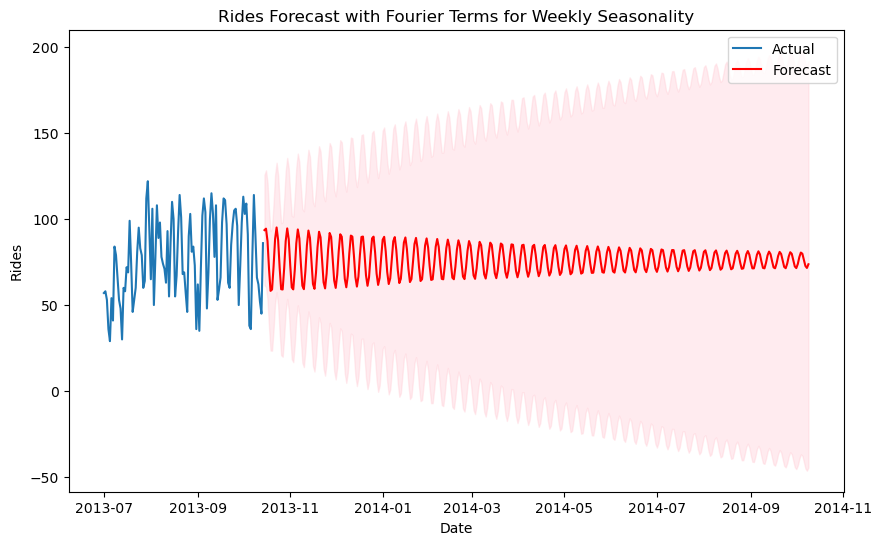

In [9]:
from pmdarima import auto_arima
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `citi_train` is a DataFrame with a 'rides' column and 'date' as index
# and that it has been loaded and prepared as before

# Function to generate Fourier terms for seasonality
def fourier_terms(y, K, period=7):
    # y is the time series data
    # K is the number of Fourier terms
    # period is the seasonality period
    T = np.arange(1, len(y) + 1)
    X = np.column_stack([np.sin(2 * np.pi * k * T / period) for k in range(1, K + 1)] + 
                        [np.cos(2 * np.pi * k * T / period) for k in range(1, K + 1)])
    return X

# Generate Fourier terms for the original time series
K = 3
fourier_terms_xreg = fourier_terms(citi_train['rides'], K=K)

# Generate Fourier terms for the future periods to forecast
n_periods = 360
future_periods = np.arange(len(citi_train['rides']) + 1, len(citi_train['rides']) + n_periods + 1)
fourier_terms_future = fourier_terms(future_periods, K=K, period=7)

# Fit ARIMA model with Fourier terms as exogenous variables
arima_model = auto_arima(citi_train['rides'], exogenous=fourier_terms_xreg, seasonal=False, trace=True,
                         error_action='ignore', suppress_warnings=True)

# Forecast with the ARIMA model using future Fourier terms as exogenous variables
forecast, conf_int = arima_model.predict(n_periods=n_periods, exogenous=fourier_terms_future, return_conf_int=True)

# Plotting the forecast and actual values
plt.figure(figsize=(10, 6))
plt.plot(citi_train.index, citi_train['rides'], label='Actual')
future_dates = pd.date_range(citi_train.index[-1], periods=n_periods + 1, closed='right')
plt.plot(future_dates, forecast, label='Forecast', color='red')
plt.fill_between(future_dates, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Rides')
plt.title('Rides Forecast with Fourier Terms for Weekly Seasonality')
plt.legend()
plt.show()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=930.096, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=972.763, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=973.850, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=962.223, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=970.776, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=939.222, Time=0.03 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=932.147, Time=0.09 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=935.341, Time=0.03 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=928.260, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=942.622, Time=0.02 sec
 A

/var/folders/_8/pmt00p0n2zsgw2rvt0djf05m0000gp/T/ipykernel_54117/2926279571.py:39: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(citi_train['date'].iloc[-1], periods=n_periods + 1, closed='right')


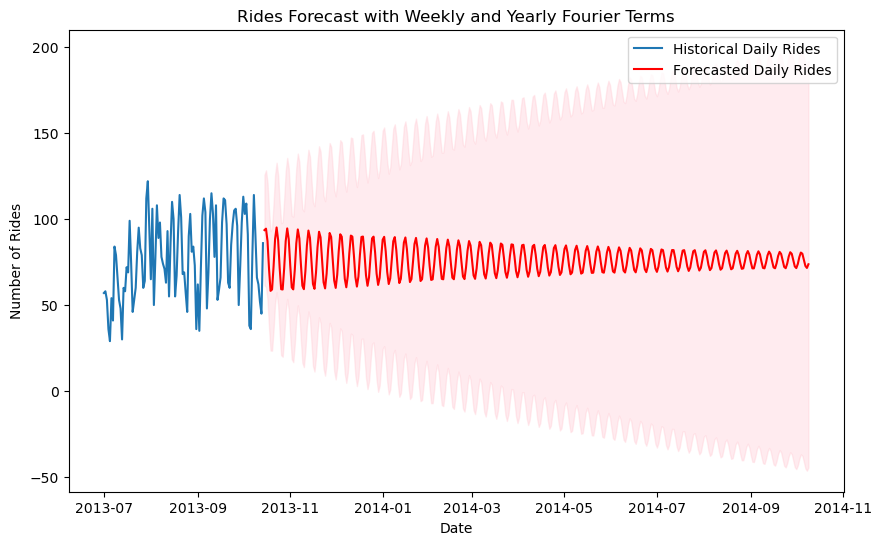

In [10]:
from pmdarima import auto_arima
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to generate Fourier terms for seasonality
def fourier_terms(time, K, period=7):
    # Generate both sine and cosine terms
    X = np.column_stack([np.sin(2 * np.pi * k * time / period) for k in range(1, K + 1)] + 
                        [np.cos(2 * np.pi * k * time / period) for k in range(1, K + 1)])
    return X

# Number of observations
n = len(citi_train['rides'])
time = np.arange(1, n + 1)

# Generate Fourier terms for weekly and yearly seasonality for historical data
weekly_fourier = fourier_terms(time, K=3, period=7)
yearly_fourier = fourier_terms(time, K=6, period=365.25)
xreg_fourier = np.hstack([weekly_fourier, yearly_fourier])

# Future periods for forecasting
n_periods = 360
future_time = np.arange(n + 1, n + n_periods + 1)
weekly_fourier_future = fourier_terms(future_time, K=3, period=7)
yearly_fourier_future = fourier_terms(future_time, K=6, period=365.25)
xreg_fourier_future = np.hstack([weekly_fourier_future, yearly_fourier_future])

# Fit ARIMA model
arima_model = auto_arima(citi_train['rides'], exogenous=xreg_fourier, seasonal=False, trace=True,
                         error_action='ignore', suppress_warnings=True)

# Forecast
forecast, conf_int = arima_model.predict(n_periods=n_periods, exogenous=xreg_fourier_future, return_conf_int=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(citi_train['date'], citi_train['rides'], label='Historical Daily Rides')
future_dates = pd.date_range(citi_train['date'].iloc[-1], periods=n_periods + 1, closed='right')
plt.plot(future_dates, forecast, label='Forecasted Daily Rides', color='red')
plt.fill_between(future_dates, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Number of Rides')
plt.title('Rides Forecast with Weekly and Yearly Fourier Terms')
plt.legend()
plt.show()


23:48:26 - cmdstanpy - INFO - Chain [1] start processing
23:48:26 - cmdstanpy - INFO - Chain [1] done processing


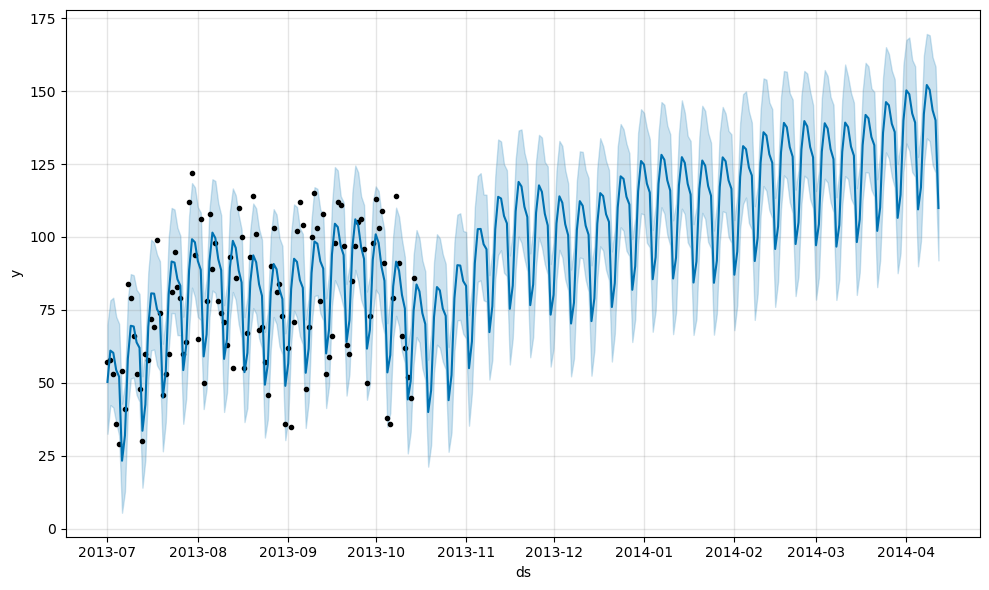

In [11]:
from prophet import Prophet
import pandas as pd

# Assuming `citi_train` is already loaded and contains 'date' and 'rides' columns

# Prepare the DataFrame for Prophet
pp = citi_train.rename(columns={'date': 'ds', 'rides': 'y'})

# Initialize and fit the Prophet model
m = Prophet(changepoint_prior_scale=0.5, yearly_seasonality=8, weekly_seasonality=3)
m.add_seasonality(name='yearly', period=365.25, fourier_order=8)
m.add_seasonality(name='weekly', period=7, fourier_order=3)

# If you specifically need to use MCMC for uncertainty estimates, you can set the mcmc.samples parameter.
# This will significantly increase fitting time.
# m = Prophet(mcmc_samples=4000)

m.fit(pp)

# Make a future DataFrame and predict
pf = m.make_future_dataframe(periods=180)
pfc = m.predict(pf)

# Plot the forecast
fig = m.plot(pfc)


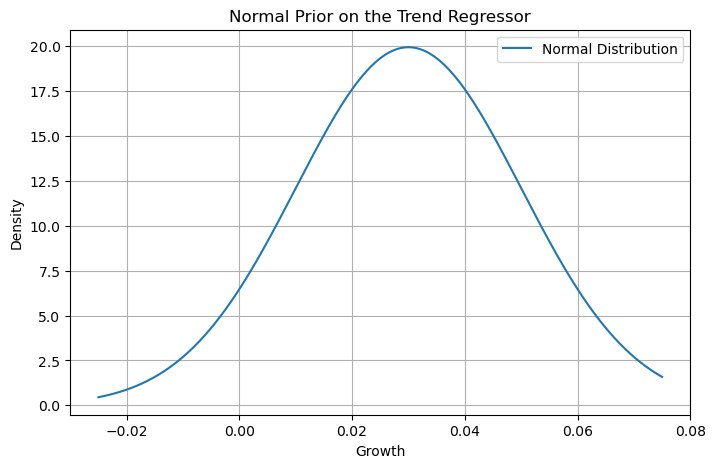

Probability of drawing a negative trend: 6.68%


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the range and parameters for the normal distribution
x = np.linspace(-0.025, 0.075, 1000)
mu = 0.03
sigma = 0.02

# Calculate the density
y = norm.pdf(x, mu, sigma)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(x, y, label='Normal Distribution')
plt.xlabel('Growth')
plt.ylabel('Density')
plt.title('Normal Prior on the Trend Regressor')
plt.grid(True)
plt.legend()
plt.show()

# Calculate the probability of drawing a negative trend
prob_negative_trend = norm.cdf(0, mu, sigma) * 100
print(f"Probability of drawing a negative trend: {prob_negative_trend:.2f}%")


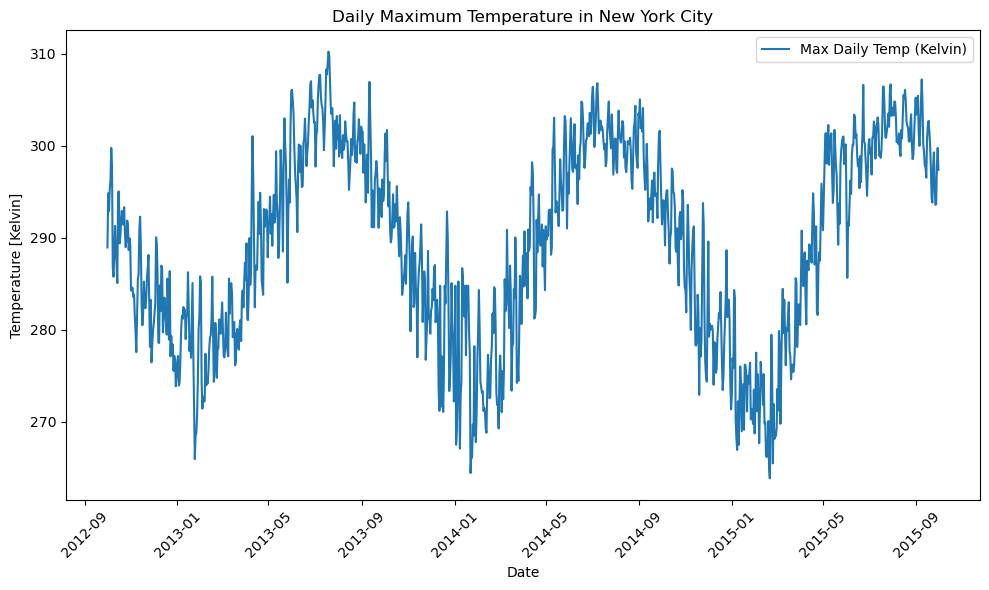

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the 'temperature.csv' file is in your current working directory
temperature = pd.read_csv("temperature.csv")

# Convert 'datetime' to datetime object and extract New York temperature
temperature['datetime'] = pd.to_datetime(temperature['datetime'])
temperature['New York'] = pd.to_numeric(temperature['New York'], errors='coerce')  # Ensure numeric

# Summarize the dataset to daily observations for New York City
daily_temp = temperature[['datetime', 'New York']].copy()
daily_temp.rename(columns={'New York': 'temperature'}, inplace=True)
daily_temp['date'] = daily_temp['datetime'].dt.date
daily_temp = daily_temp.groupby('date')['temperature'].max().reset_index()
daily_temp['max_temp'] = daily_temp['temperature'].round()
daily_temp = daily_temp[daily_temp['max_temp'].notna()]  # Remove NaN values
daily_temp = daily_temp[daily_temp['date'] < pd.to_datetime("2015-10-01").date()]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(daily_temp['date'], daily_temp['temperature'], label='Max Daily Temp (Kelvin)')
plt.xlabel('Date')
plt.ylabel('Temperature [Kelvin]')
plt.title('Daily Maximum Temperature in New York City')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()  # Adjusts plot parameters to give some padding
plt.show()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


/Users/diogoribeiro/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/diogoribeiro/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/diogoribeiro/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/diogoribeiro/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 16 seconds.


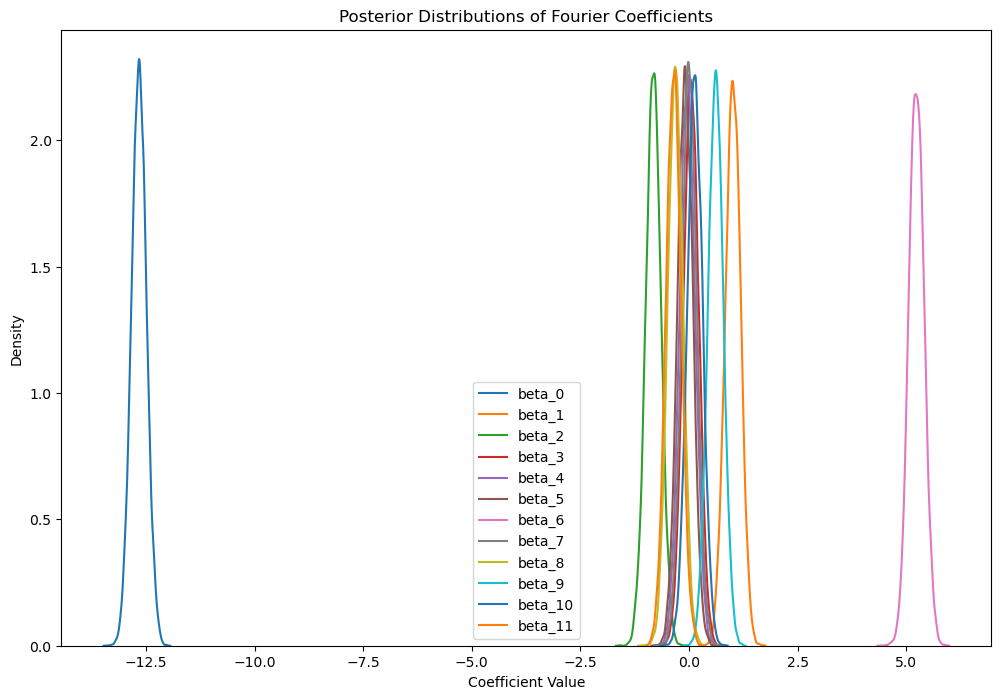

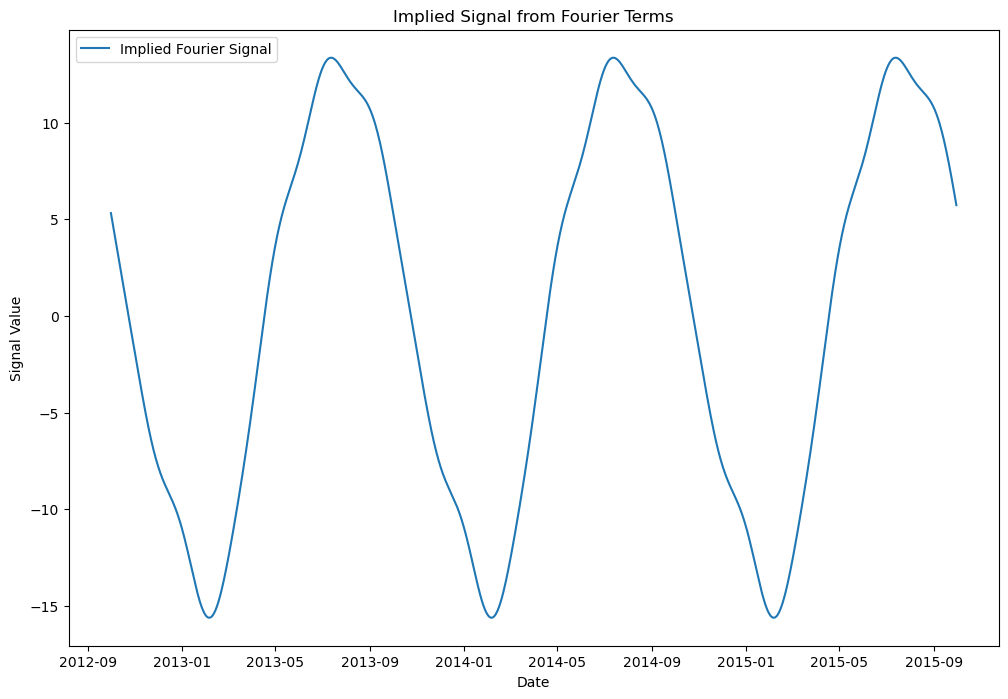

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/diogoribeiro/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'beta\n0'}>,
        <AxesSubplot:title={'center':'beta\n1'}>,
        <AxesSubplot:title={'center':'beta\n2'}>],
       [<AxesSubplot:title={'center':'beta\n3'}>,
        <AxesSubplot:title={'center':'beta\n4'}>,
        <AxesSubplot:title={'center':'beta\n5'}>],
       [<AxesSubplot:title={'center':'beta\n6'}>,
        <AxesSubplot:title={'center':'beta\n7'}>,
        <AxesSubplot:title={'center':'beta\n8'}>],
       [<AxesSubplot:title={'center':'beta\n9'}>,
        <AxesSubplot:title={'center':'beta\n10'}>,
        <AxesSubplot:title={'center':'beta\n11'}>]], dtype=object)

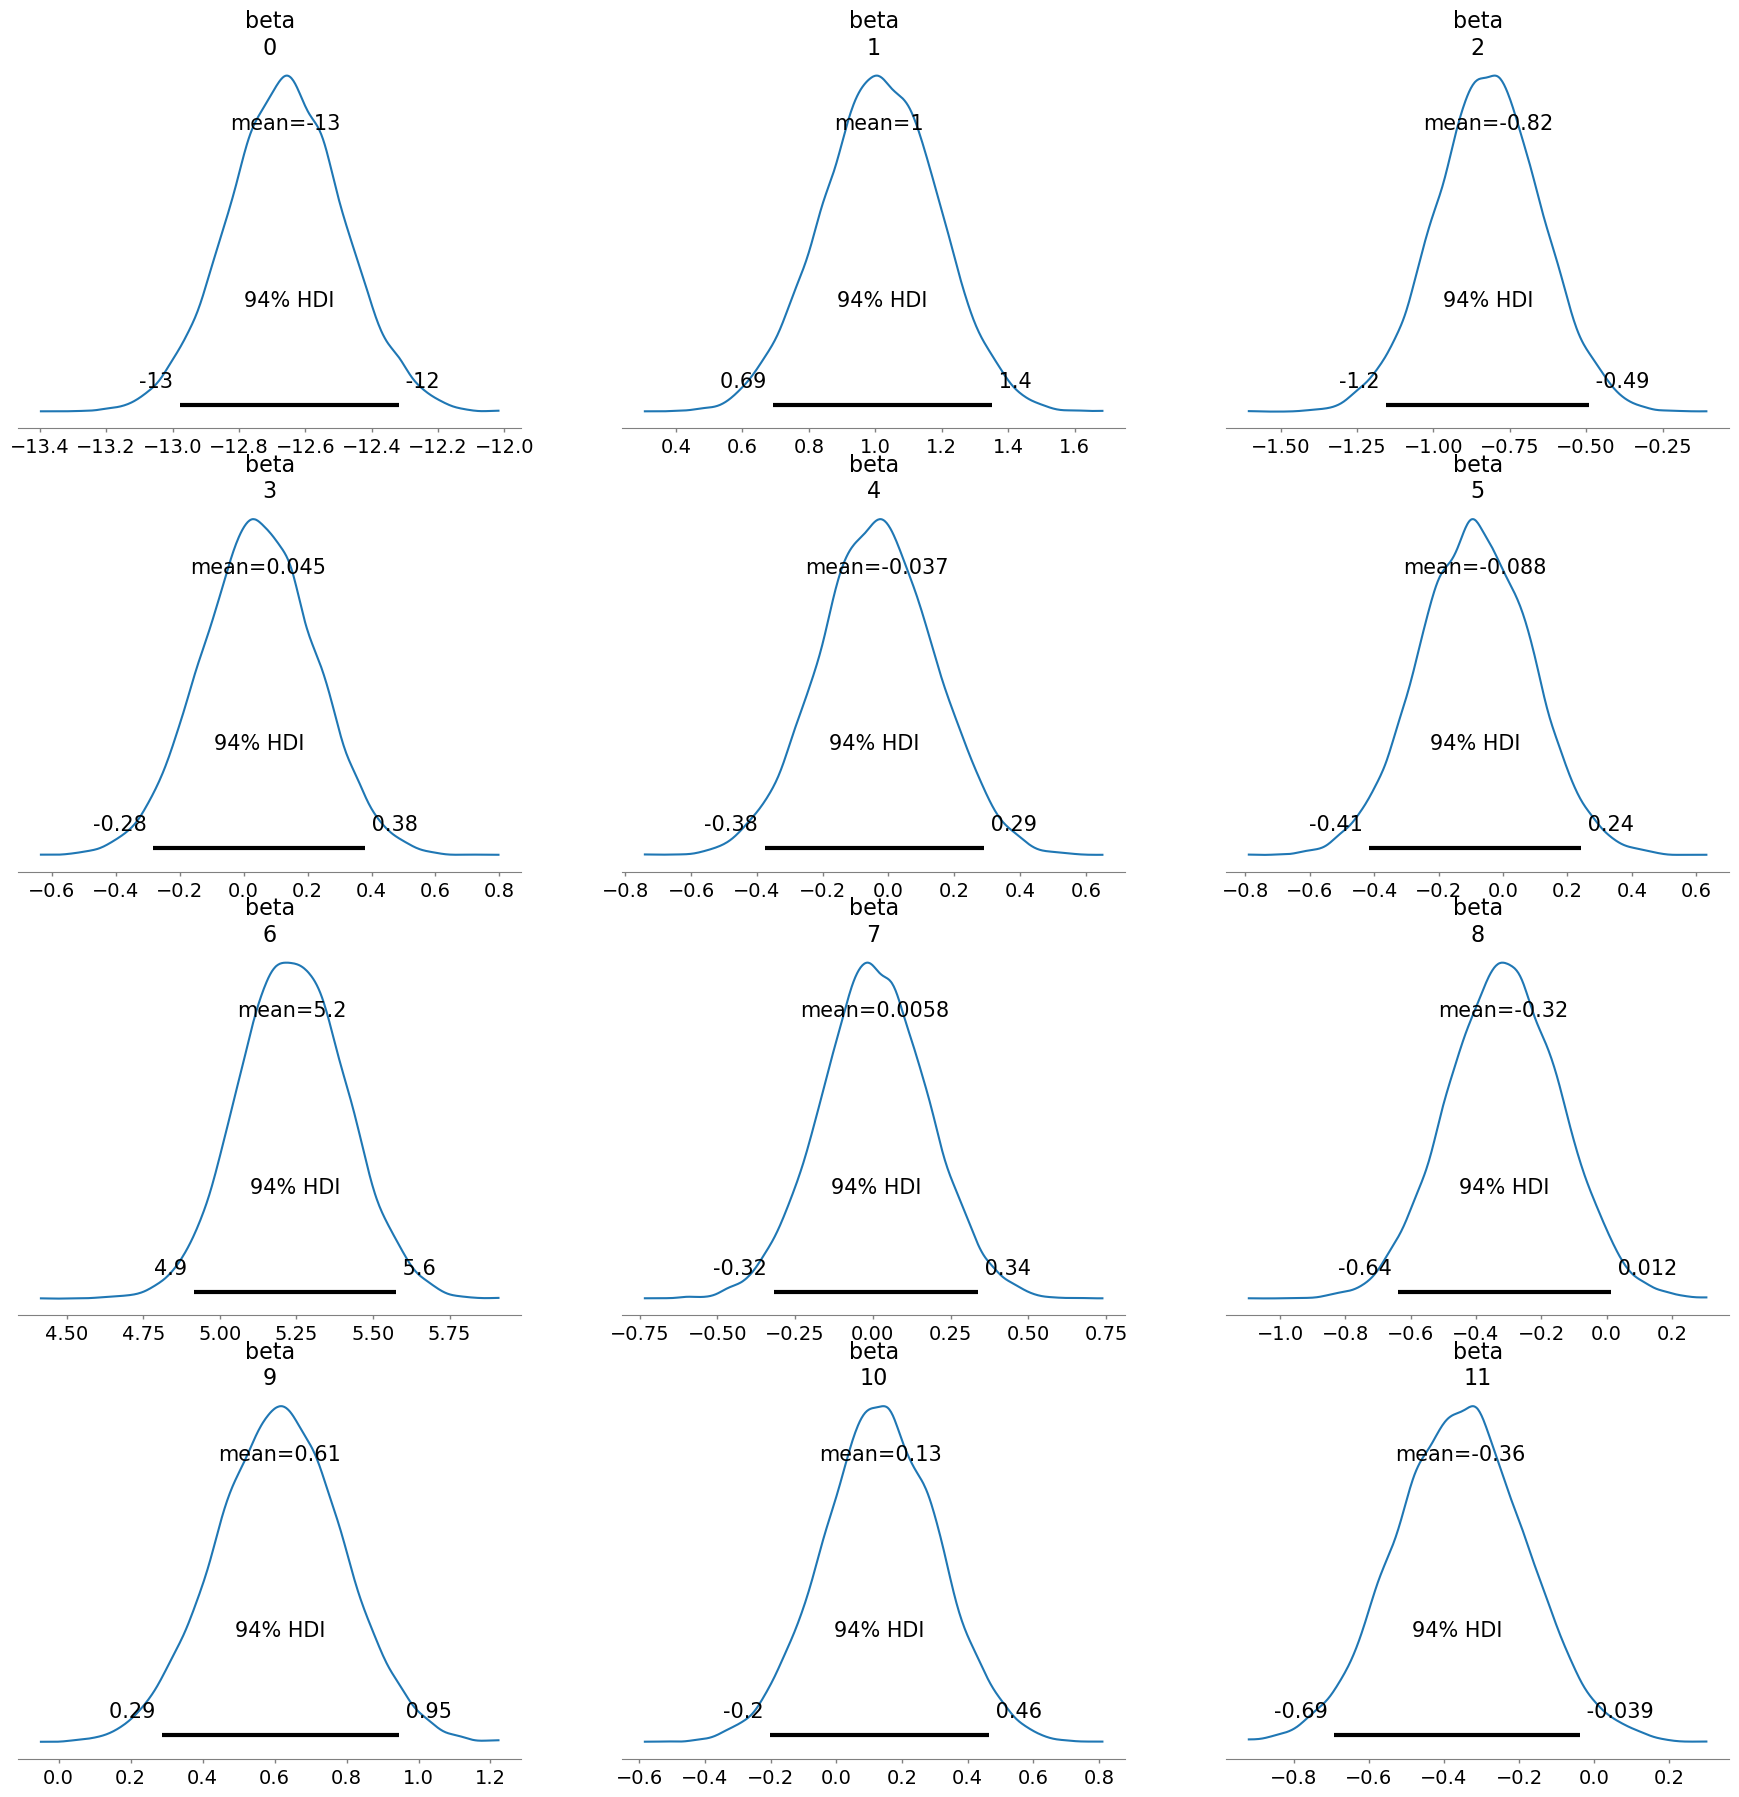

In [22]:
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming daily_temp DataFrame is prepared with 'date' and 'max_temp' columns
# and fourier terms are generated as described in previous Python examples

# Generate Fourier terms for the given dates
def create_fourier_features(dates, K=6):
    # Ensure dates is a series of pandas timestamps for consistent dtype
    t = np.arange(len(dates))
    features = np.column_stack([
        np.sin(2 * np.pi * (k+1) * t / 365.25) for k in range(K)
    ] + [
        np.cos(2 * np.pi * (k+1) * t / 365.25) for k in range(K)
    ])
    return features

# Prepare the data
dates = pd.to_datetime(daily_temp['date'])
xreg = create_fourier_features(dates, K=6)
y_t = daily_temp['max_temp'].values - daily_temp['max_temp'].min()

# Fit the Bayesian model using PyMC3
with pm.Model() as model:
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=(2*6,))  # 2*K because of sin and cos
    sigma = pm.HalfNormal('sigma', sd=1)
    
    # Expected value (mu) of outcome, linear model
    mu = alpha + tt.dot(xreg, beta)
    
    # Likelihood (sampling distribution) of observations
    y_obs = pm.Normal('y_obs', mu=mu, sd=sigma, observed=y_t)
    
    # Inference
    trace = pm.sample(4000, return_inferencedata=False)

# Extract posterior samples
beta_samples = pd.DataFrame({f'beta_{i}': trace['beta'][:, i] for i in range(2*6)})

# Plot the posterior distributions of the Fourier coefficients
plt.figure(figsize=(12, 8))
for i in range(2*6):
    sns.kdeplot(beta_samples[f'beta_{i}'], label=f'beta_{i}')
plt.xlabel('Coefficient Value')
plt.ylabel('Density')
plt.title('Posterior Distributions of Fourier Coefficients')
plt.legend()
plt.show()

# Calculate the implied signal from the Fourier terms
fourier_signal = np.dot(xreg, np.mean(trace['beta'], axis=0))
plt.figure(figsize=(12, 8))
plt.plot(dates, fourier_signal, label='Implied Fourier Signal')
plt.xlabel('Date')
plt.ylabel('Signal Value')
plt.title('Implied Signal from Fourier Terms')
plt.legend()
plt.show()


# Assuming `trace` is your MultiTrace object from pm.sample()
beta_means = np.mean(trace['beta'], axis=0)
beta_sds = np.std(trace['beta'], axis=0)

# If you wish to plot posterior distributions of the Fourier coefficients
import arviz as az

# Convert MultiTrace to InferenceData (if you want to use ArviZ for plotting)
inference_data = az.from_pymc3(trace)

# Now you can use ArviZ for plotting
az.plot_posterior(inference_data, var_names=['beta'])


In [26]:
import pymc3 as pm
import numpy as np
import theano.tensor as tt

# Assuming `fourier_citi`, `trend_citi`, `xreg_citi`, `y_citi`, and previously determined `beta_means` and `beta_sds` are prepared as described

# Assuming citi_train['date'] is a pandas Series of datetime64 type
dates = pd.to_datetime(citi_train['date'])
fourier_features_citi = create_fourier_features(dates)

# Preparing the Fourier terms DataFrame
fourier_citi = pd.DataFrame(fourier_features_citi, columns=[f'fourier_{i}' for i in range(1, 2*6+1)])


# Trend as a simple linear term over time
trend_citi = np.arange(len(citi_train)) / 365.25

# Assuming there are other covariates in citi_train related to weekdays ('wday1' to 'wday6')
xreg_citi = citi_train.filter(regex='^wday').to_numpy()


# Outcome variable: daily ride counts
y_citi = citi_train['rides'].to_numpy()

# Number of Fourier terms
num_fourier_terms = 2 * 6  # 6 sine and 6 cosine

# Assuming xreg_citi is already defined and contains weekday indicators
# Calculate the total number of covariates
K_citi = xreg_citi.shape[1]


with pm.Model() as model:
    # Trend prior
    alpha = pm.Normal('alpha', mu=0.03, sd=0.02)
    
    # Fourier coefficients priors
    beta_fourier = pm.Normal('beta_fourier', mu=beta_means, sd=beta_sds, shape=(12,))
    
    # Additional regression coefficients for other predictors, if any
    beta_xreg = pm.Normal('beta_xreg', mu=0, sd=1, shape=(K_citi,))
    
    # Model equation
    mu = alpha + tt.dot(fourier_citi, beta_fourier) + tt.dot(xreg_citi, beta_xreg)
    
    # Assuming a Poisson likelihood (modify as necessary, e.g., to Negative Binomial if overdispersion is present)
    y_obs = pm.Poisson('y_obs', mu=tt.exp(mu), observed=y_citi)
    
    # Sampling
    trace = pm.sample(4000, chains=2, target_accept=0.95)


/Users/diogoribeiro/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta_xreg, beta_fourier, alpha]


/Users/diogoribeiro/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/diogoribeiro/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 23 seconds.


In [34]:
import numpy as np
import arviz as az

# Assuming 'idata' is your InferenceData object obtained from PyMC sampling
# For clarity and following PyMC and ArviZ conventions

# Extract alpha (intercept) samples
alpha_samples = idata.posterior["alpha"].values

# Extract beta_fourier samples
beta_fourier_samples = idata.posterior["beta_fourier"].values

# If there's 'beta_xreg' representing additional regression coefficients
beta_xreg_samples = idata.posterior["beta_xreg"].values

# Assuming the model structure and variable names based on the provided information
# There's no 'beta_trend' based on your context; adjust accordingly if other trend representations exist

# Calculate the mean of y_hats if posterior predictive checks were performed
# Ensure 'y_obs' matches your model's observed variable name
if hasattr(idata, 'posterior_predictive'):
    y_hats_mean = idata.posterior_predictive["y_obs"].mean(axis=(0, 1))  # Mean over chains and draws

# Note: Direct extraction of 'y_hats' as means from posterior predictive requires generating these predictions during sampling

# For forecasting future outcomes, you'll need to apply the same process of generating predictors for future dates
# and then use the extracted samples to compute expected values or distributions of outcomes for those dates

# Example of applying mean coefficients for point forecast (simplified)
# future_fourier_features and future_xreg_values need to be prepared similarly to past data preparation
alpha_mean = np.mean(alpha_samples)
beta_fourier_mean = np.mean(beta_fourier_samples, axis=(0, 1))
beta_xreg_mean = np.mean(beta_xreg_samples, axis=(0, 1))

# future_mu = alpha_mean + np.dot(future_fourier_features, beta_fourier_mean) + np.dot(future_xreg_values, beta_xreg_mean)
# Assuming a link function or direct application based on model specification for final forecast values


In [33]:
beta_xreg_samples

array([[[0.61087768, 0.96830227, 1.09723198, 1.06345944, 0.9976038 ,
         0.95272751],
        [0.66047621, 0.9861953 , 1.07908136, 1.06326773, 1.02383964,
         0.91514662],
        [0.63780857, 1.02243512, 1.08269329, 1.06294333, 0.96484703,
         0.99764591],
        ...,
        [0.65870097, 1.02026606, 1.11418886, 1.11470328, 1.10692425,
         0.96361385],
        [0.67259812, 1.03340861, 1.10977027, 1.10392238, 1.06708794,
         0.962328  ],
        [0.63130198, 0.95572786, 1.05185208, 1.04622081, 0.9736448 ,
         0.94474876]],

       [[0.64277795, 1.0769518 , 1.14186803, 1.08827273, 1.04684293,
         0.9367175 ],
        [0.68868725, 1.07401413, 1.11393958, 1.00454069, 1.03168537,
         0.9695238 ],
        [0.70651587, 1.06602284, 1.10466335, 1.03372018, 1.02160569,
         0.96315649],
        ...,
        [0.73941565, 1.09831481, 1.11933766, 1.13289309, 1.04998565,
         0.99743324],
        [0.66723703, 1.0286894 , 1.11116604, 1.10073061, 1.077